In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [33]:
%matplotlib inline
plt.style.use("fivethirtyeight")

# Initial exploration

In [34]:
df = pd.read_csv("blackjack.csv")

In [35]:
df.shape

(60000, 20)

In [36]:
df.describe()

,num_decks,dealer_open,dealer_initial,dealer_hit,dealer_num_hits,dealer_final,dealer_busts,player_card_one,player_card_two,player_initial,player_hit,player_num_hits,player_final,player_busts,player_loses,draw,player_wins,strategy
count,60000.0,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000,60000.000000
mean,4.0,6.534217,14.558133,0.408883,0.564167,18.109300,0.180900,6.536367,6.534283,14.550317,0.574683,0.846050,19.909783,0.300600,0.549750,0.06935,0.380900,0.500000
std,0.0,3.158923,4.087807,0.491632,0.784024,4.371976,0.384939,3.149081,3.158178,4.076103,0.494395,0.899275,3.897033,0.458523,0.497523,0.25405,0.485612,0.500004
min,4.0,1.000000,4.000000,0.000000,0.000000,4.000000,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,4.0,4.000000,12.000000,0.000000,0.000000,16.000000,0.000000,4.000000,4.000000,12.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,4.0,7.000000,15.000000,0.000000,0.000000,19.000000,0.000000,7.000000,7.000000,15.000000,1.000000,1.000000,20.000000,0.000000,1.000000,0.00000,0.000000,0.500000
75%,4.0,10.000000,18.000000,1.000000,1.000000,21.000000,0.000000,10.000000,10.000000,18.000000,1.000000,1.000000,22.000000,1.000000,1.000000,0.00000,1.000000,1.000000
max,4.0,10.000000,21.000000,1.000000,6.000000,26.000000,1.000000,10.000000,10.000000,21.000000,1.000000,7.000000,28.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [37]:
df.groupby("strategy")[["player_wins"]].sum()

,player_wins
strategy,
0,10748
1,12106


## Dealer's open card

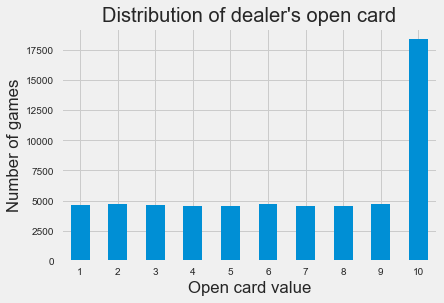

In [38]:
df["dealer_open"].value_counts(sort=False).plot(kind="bar", rot=0);
plt.xlabel("Open card value");
plt.ylabel("Number of games");
plt.title("Distribution of dealer's open card");

## Player's card one

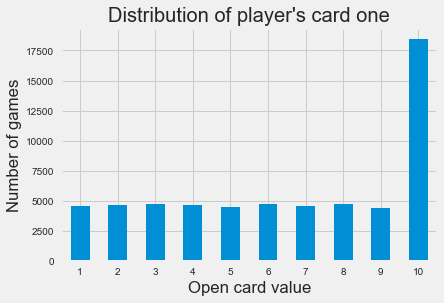

In [39]:
df["player_card_one"].value_counts(sort=False).plot(kind="bar", rot=0);
plt.xlabel("Open card value");
plt.ylabel("Number of games");
plt.title("Distribution of player's card one");

## Player's card two

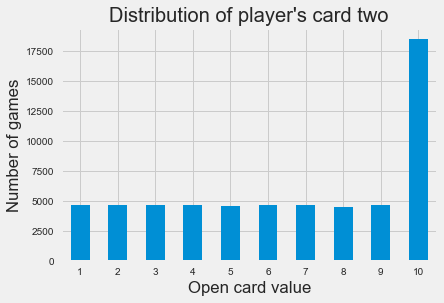

In [40]:
df["player_card_two"].value_counts(sort=False).plot(kind="bar", rot=0);
plt.xlabel("Open card value");
plt.ylabel("Number of games");
plt.title("Distribution of player's card two");

## Player's possible points

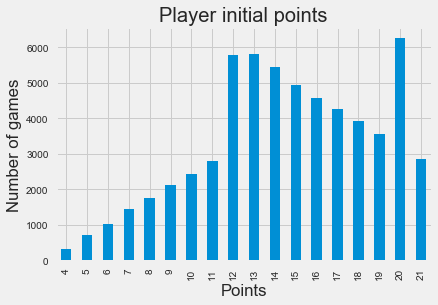

In [41]:
df.player_initial.value_counts().sort_index().plot(kind="bar");
plt.xlabel("Points");
plt.ylabel("Number of games");
plt.title("Player initial points");

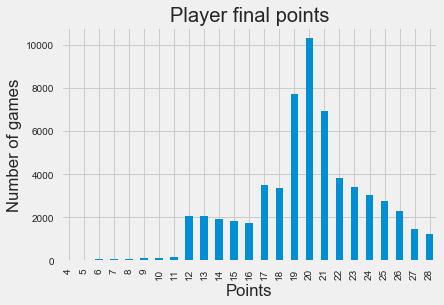

In [42]:
df.player_final.value_counts().sort_index().plot(kind="bar");
plt.xlabel("Points");
plt.ylabel("Number of games");
plt.title("Player final points");

## Dealer's possible points

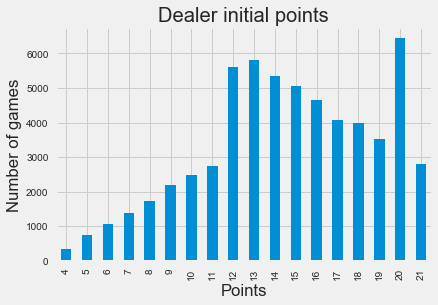

In [43]:
df.dealer_initial.value_counts().sort_index().plot(kind="bar");
plt.xlabel("Points");
plt.ylabel("Number of games");
plt.title("Dealer initial points");

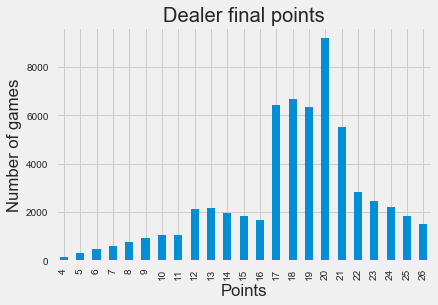

In [44]:
df.dealer_final.value_counts().sort_index().plot(kind="bar");
plt.xlabel("Points");
plt.ylabel("Number of games");
plt.title("Dealer final points");

## Comparison of final points

In [47]:
player_ran = df[df.strategy==0].player_final.value_counts().sort_index().to_frame()
player_ran.reset_index(inplace=True)
player_ran.columns = ["final_points", "num_games"]
dealer_ran = df[df.strategy==0].dealer_final.value_counts().sort_index().to_frame()
dealer_ran.reset_index(inplace=True)
dealer_ran.columns = ["final_points", "num_games"]

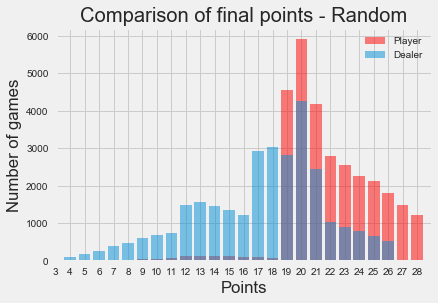

In [49]:
plt.bar(player_ran.final_points, player_ran.num_games, label="Player", 
        color="r", alpha=0.5)
plt.bar(dealer_ran.final_points, dealer_ran.num_games, label="Dealer", 
        alpha=0.5)
plt.xlabel("Points");
plt.ylabel("Number of games");
plt.title("Comparison of final points - Random");
plt.xlim(3,29);
plt.xticks(np.arange(3,29));
plt.legend();

In [51]:
player_rec = df[df.strategy==1].player_final.value_counts().sort_index().to_frame()
player_rec.reset_index(inplace=True)
player_rec.columns = ["final_points", "num_games"]
dealer_rec = df[df.strategy==1].dealer_final.value_counts().sort_index().to_frame()
dealer_rec.reset_index(inplace=True)
dealer_rec.columns = ["final_points", "num_games"]

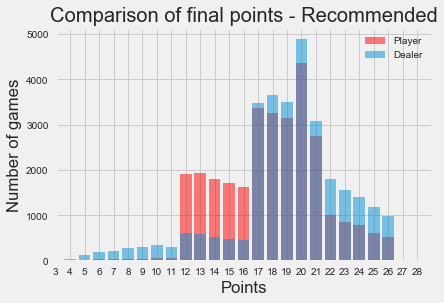

In [52]:
plt.bar(player_rec.final_points, player_rec.num_games, label="Player", 
        color="r", alpha=0.5)
plt.bar(dealer_rec.final_points, dealer_rec.num_games, label="Dealer", 
        alpha=0.5)
plt.xlabel("Points");
plt.ylabel("Number of games");
plt.title("Comparison of final points - Recommended");
plt.xlim(3,29);
plt.xticks(np.arange(3,29));
plt.legend();

## Findings

- Random strategy
    - Player is more likely to bust
    - Player is also more likely to get 19-21 points
- Recommended strategy
    - Dealer is more likely to bust
    - Dealer is also more likely to get 17-21 points
- Visually, can't really tell if the recommended strategy is better
    - You have lower chance of busting but you also have lower chance of getting higher values

# Recommended vs random strategy

In [53]:
result_cols = ["dealer_busts", "player_busts", "player_loses", "draw", "player_wins"]

In [54]:
# Simulate trials of 100 games
def sim_trial(strategy=0):
    sub = df[df.strategy == strategy]
    to_get = np.random.choice(sub.index, 100)
    trials = sub.ix[to_get]
    trials = trials[result_cols]
    return pd.DataFrame(trials.sum()).T

In [55]:
sim_trial()

,dealer_busts,player_busts,player_loses,draw,player_wins
0,16,52,59,3,38


In [56]:
def n_trials(strategy=0, n=5000):
    trials = sim_trial(strategy=strategy)
    for _ in range(n-1):
        trials = pd.concat([trials, sim_trial(strategy=strategy)])
    return trials

In [70]:
ran = n_trials()
rec = n_trials(strategy=1)

In [59]:
# combine with older files
def save_file(trials, filename):
    try:
        old_trials = pd.read_csv(filename+".csv")
        trials = pd.concat([old_trials, trials])
    except:
        pass
    trials.to_csv(filename+".csv", index=False)

In [71]:
save_file(ran, "ran_trials")
save_file(rec, "rec_trials")

In [72]:
ran = pd.read_csv("ran_trials.csv")
rec = pd.read_csv("rec_trials.csv")

In [73]:
print (ran.shape)
print (rec.shape)

(20000, 5)
(20000, 5)


## Number of wins

$H_0$: There is no difference in expected number of wins for the player between a random strategy and a recommended strategy.

$H_1$: There is a difference in expected number of wins for the player between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

- Instead of simulating trials, we'll draw random samples from the dataset that we've created

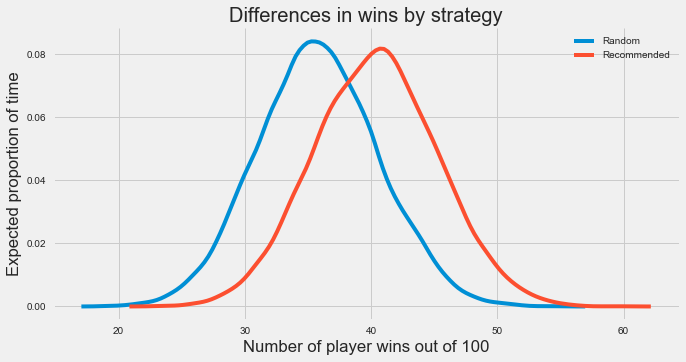

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(ran.player_wins, 
             hist=False, label="Random");
sns.distplot(rec.player_wins, 
             hist=False, label="Recommended");
ax.set_title("Differences in wins by strategy");
ax.set_ylabel("Expected proportion of time");
ax.set_xlabel("Number of player wins out of 100");
sns.despine();

In [75]:
# Is the difference significant?
stats.ttest_ind(ran.player_wins, rec.player_wins)

Ttest_indResult(statistic=-94.784202490355966, pvalue=0.0)

## Number of losses

$H_0$: There is no difference in expected number of losses for the player between a random strategy and a recommended strategy.

$H_1$: There is a difference in expected number of losses for the player between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

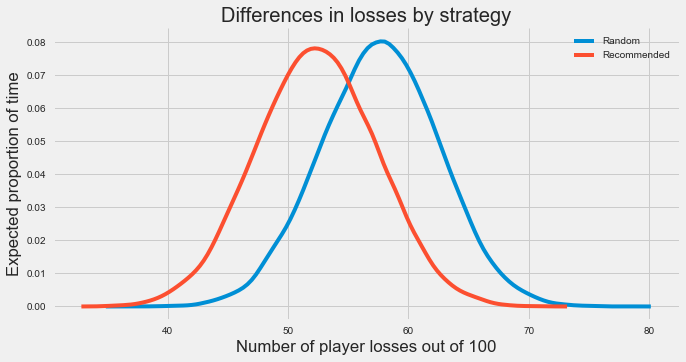

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(ran.player_loses, 
             hist=False, label="Random");
sns.distplot(rec.player_loses, 
             hist=False, label="Recommended");
ax.set_title("Differences in losses by strategy");
ax.set_ylabel("Expected proportion of time");
ax.set_xlabel("Number of player losses out of 100");
sns.despine();

In [77]:
# Is the difference significant?
stats.ttest_ind(ran.player_loses, rec.player_loses)

Ttest_indResult(statistic=106.08240637511028, pvalue=0.0)

## Number of busts

$H_0$: There is no difference in expected number of busts for the player between a random strategy and a recommended strategy.

$H_1$: There is a difference in expected number of busts for the player between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

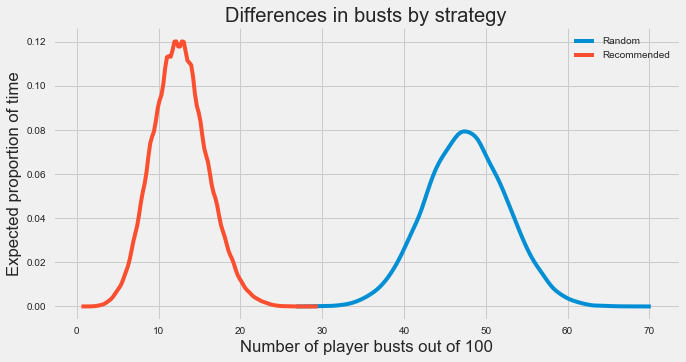

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(ran.player_busts, 
             hist=False, label="Random");
sns.distplot(rec.player_busts, 
             hist=False, label="Recommended");
ax.set_title("Differences in busts by strategy");
ax.set_ylabel("Expected proportion of time");
ax.set_xlabel("Number of player busts out of 100");
sns.despine();

In [79]:
# Is the difference significant?
stats.ttest_ind(ran.player_busts, rec.player_busts)

Ttest_indResult(statistic=825.83734325411581, pvalue=0.0)

## What about dealer busts?

$H_0$: There is no difference in expected number of busts for the dealer between a random strategy and a recommended strategy.

$H_1$: There is a difference in expected number of busts for the dealer between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

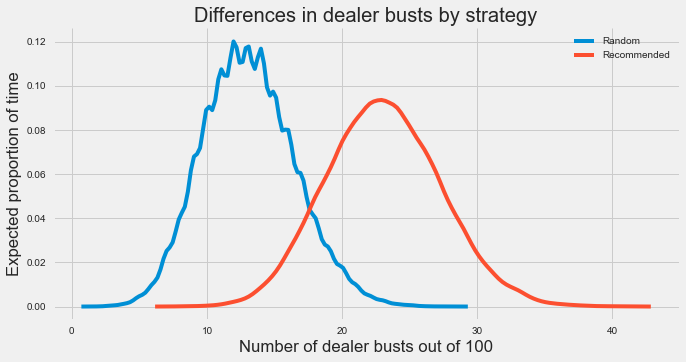

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(ran.dealer_busts, 
             hist=False, label="Random");
sns.distplot(rec.dealer_busts, 
             hist=False, label="Recommended");
ax.set_title("Differences in dealer busts by strategy");
ax.set_ylabel("Expected proportion of time");
ax.set_xlabel("Number of dealer busts out of 100");
sns.despine();

In [81]:
# Is the difference significant?
stats.ttest_ind(ran.dealer_busts, rec.dealer_busts)

Ttest_indResult(statistic=-261.81160458765106, pvalue=0.0)

## Findings

- Using the recommended strategy
    - Expected wins are greater
    - Expected losses are lower
    - Expected player busts are lower
    - Expected dealer busts are higher
        - Does this make sense?
        - Why would the player's strategy affect the dealer's hand?
- Seems like using the recommended strategy does improve our chances of winning
    - But is it enough?

# In-depth exploration

In [82]:
df.head()

,num_decks,dealer_open,dealer_initial,dealer_hit,dealer_num_hits,dealer_final,dealer_busts,player_card_one,player_card_two,player_initial,player_hit,player_num_hits,player_final,player_busts,player_loses,draw,player_wins,strategy,dealer_hand,player_hand
0,4,10,18,0,0,18,0,5,2,7,1,3,22,1,1,0,0,0,"Q,8","5,2,5,2,8"
1,4,7,17,0,0,17,0,10,9,19,0,0,19,0,0,0,1,0,"7,K","Q,9"
2,4,5,13,0,0,13,0,9,4,13,1,1,23,1,1,0,0,0,"5,8","9,4,K"
3,4,10,13,1,1,21,0,10,10,20,0,0,20,0,1,0,0,0,"K,3,8","K,Q"
4,4,7,14,1,2,19,0,8,2,10,1,1,20,0,0,0,1,0,"7,7,A,4","8,2,10"


In [83]:
score_cols = ["player_loses", "draw", "player_wins"]

## Is splitting 8's always better than just keeping them?

- And does the strategy affect that?

In [84]:
def get_combi(cards):
    card_list = list(cards)
    card_list.sort()
    card_list = [str(i) for i in card_list]
    return "".join(card_list)

In [85]:
def get_other(cards, number):
    card_list = list(cards)
    card_list.remove(number)
    return card_list[0]

In [86]:
eights = df.copy()
eights = eights[(df.player_card_one == 8) | (df.player_card_two == 8)]
eights = eights[["player_card_one", "player_card_two", "player_wins", "strategy"]]
eights.reset_index(drop=True, inplace=True)

In [87]:
eights["combination"] = eights[["player_card_one", "player_card_two"]].apply(get_combi, axis=1)

In [88]:
eights.head()

,player_card_one,player_card_two,player_wins,strategy,combination
0,8,2,1,0,28
1,8,6,0,0,68
2,8,9,0,0,89
3,8,7,0,0,78
4,8,1,0,0,18


In [89]:
eights.shape

(8931, 5)

In [90]:
for i in range(eights.shape[0]):
    eights.ix[i, "other"] = get_other(eights[["player_card_one", "player_card_two"]].ix[i], 8)

In [91]:
eights["other"] = eights["other"].astype(int)

In [92]:
eights.head()

,player_card_one,player_card_two,player_wins,strategy,combination,other
0,8,2,1,0,28,2
1,8,6,0,0,68,6
2,8,9,0,0,89,9
3,8,7,0,0,78,7
4,8,1,0,0,18,1


In [93]:
eights.other.value_counts()

10    2891
4      761
6      743
7      733
1      728
5      722
3      683
2      675
9      663
8      332
Name: other, dtype: int64

In [94]:
eights.head()

,player_card_one,player_card_two,player_wins,strategy,combination,other
0,8,2,1,0,28,2
1,8,6,0,0,68,6
2,8,9,0,0,89,9
3,8,7,0,0,78,7
4,8,1,0,0,18,1


In [95]:
e_wins = eights.groupby(["strategy", "other"])["player_wins"].agg([sum, len])

In [96]:
e_wins

sum   len
strategy other           
0        1      218   363
         2      135   322
         3      164   333
         4       94   369
         5      102   368
         6       83   388
         7       74   388
         8       34   168
         9       64   353
         10     239  1444
1        1      205   365
         2      176   353
         3      169   350
         4       92   392
         5       98   354
         6       98   355
         7       90   345
         8       38   164
         9       93   310
         10     602  1447

In [97]:
e_wins["prob"] = e_wins["sum"]/e_wins["len"]

In [98]:
e_wins.reset_index(inplace=True)

In [99]:
ran = e_wins[e_wins["strategy"]==0].reset_index()
rec = e_wins[e_wins["strategy"]==1].reset_index()

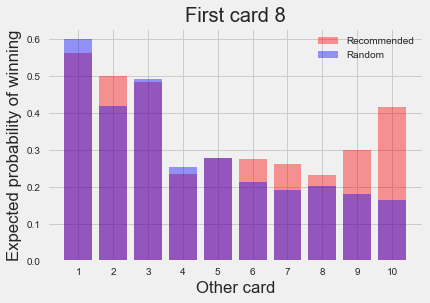

In [100]:
plt.bar(rec["other"], rec["prob"], 
        color="r", alpha=0.4, label="Recommended");
plt.bar(ran["other"], ran["prob"], 
        color="b", alpha=0.4, label="Random");
plt.title("First card 8");
plt.xticks(e_wins["other"].unique())
plt.xlabel("Other card");
plt.ylabel("Expected probability of winning");
plt.legend();

In [101]:
for i in range(1,11):
    if i != 8:
        r = stats.ttest_ind(eights["player_wins"][eights["other"]==i], eights["player_wins"][eights["other"]==8])
        if r.pvalue < 0.05:
            msg = "rejected."
        else:
            msg = "not rejected."
        print ("Null hypothesis: There is no difference in wins whether your second card is {} or 8.\nSignificance level = 5%".format(i))
        print ("Other card: {}\np-value: {:.6f}\np-value < 5%: {}\nNull hypothesis {}\n".format(i, r.pvalue, r.pvalue < 0.05, msg))

Null hypothesis: There is no difference in wins whether your second card is 1 or 8.
Significance level = 5%
Other card: 1
p-value: 0.000000
p-value < 5%: True
Null hypothesis rejected.

Null hypothesis: There is no difference in wins whether your second card is 2 or 8.
Significance level = 5%
Other card: 2
p-value: 0.000000
p-value < 5%: True
Null hypothesis rejected.

Null hypothesis: There is no difference in wins whether your second card is 3 or 8.
Significance level = 5%
Other card: 3
p-value: 0.000000
p-value < 5%: True
Null hypothesis rejected.

Null hypothesis: There is no difference in wins whether your second card is 4 or 8.
Significance level = 5%
Other card: 4
p-value: 0.324437
p-value < 5%: False
Null hypothesis not rejected.

Null hypothesis: There is no difference in wins whether your second card is 5 or 8.
Significance level = 5%
Other card: 5
p-value: 0.038231
p-value < 5%: True
Null hypothesis rejected.

Null hypothesis: There is no difference in wins whether your seco

### What about other numbers

In [105]:
def test_doubles(number):
    num_df = df.copy()
    num_df = num_df[(num_df["player_card_one"]==number) | (num_df["player_card_two"]==number)]
    num_df = num_df[["player_card_one", "player_card_two", "player_wins", "strategy"]]
    num_df.reset_index(drop=True, inplace=True)
    num_df["combination"] = num_df[["player_card_one", "player_card_two"]].apply(get_combi, axis=1)

    for i in range(num_df.shape[0]):
        num_df.ix[i, "other"] = get_other(num_df[["player_card_one", "player_card_two"]].ix[i], number)
    
    num_wins = num_df.groupby(["strategy", "other"])["player_wins"].agg([sum, len])
    num_wins["prob"] = num_wins["sum"]/num_wins["len"]
    num_wins.reset_index(inplace=True)
    
    ran = num_wins[num_wins["strategy"]==0].reset_index()
    rec = num_wins[num_wins["strategy"]==1].reset_index()
    
    plt.bar(rec["other"], rec["prob"], 
        color="r", alpha=0.4, label="Recommended");
    plt.bar(ran["other"], ran["prob"], 
            color="b", alpha=0.4, label="Random");
    plt.title("First card {}".format(number));
    plt.xticks(num_wins["other"].unique())
    plt.xlabel("Other card");
    plt.ylabel("Expected probability of winning");
    plt.legend(loc="best");
    plt.show()
    
#     for i in range(1,11):
#         if i != number:
#             r = stats.ttest_ind(num_df["player_wins"][num_df["other"]==i], num_df["player_wins"][num_df["other"]==number])
#             if r.pvalue < 0.05:
#                 msg = "rejected."
#             else:
#                 msg = "not rejected."
#             print ("Null hypothesis: There is no difference in wins whether your second card is {} or {}.\nSignificance level = 5%".format(i, number))
#             print ("Other card: {}\np-value: {:.6f}\np-value < 5%: {}\nNull hypothesis {}\n".format(i, r.pvalue, r.pvalue < 0.05, msg))

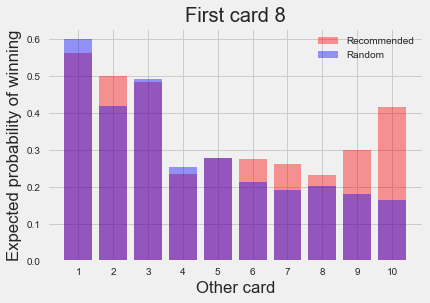

In [106]:
test_doubles(8)

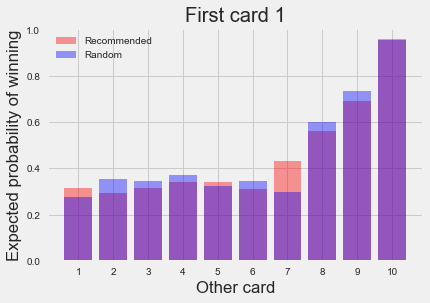

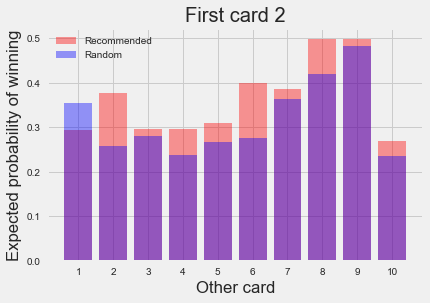

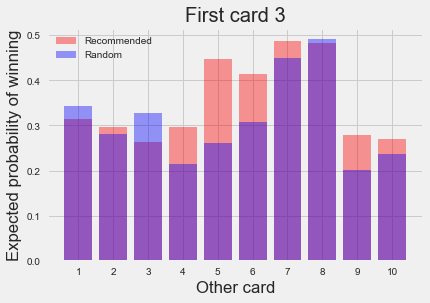

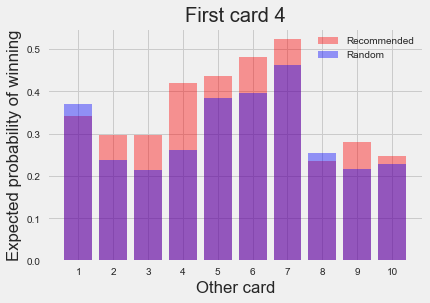

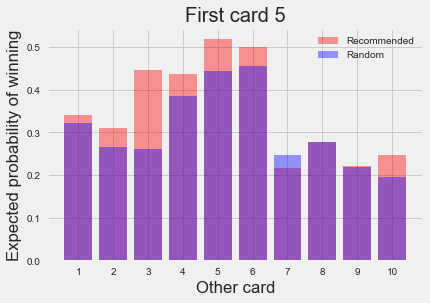

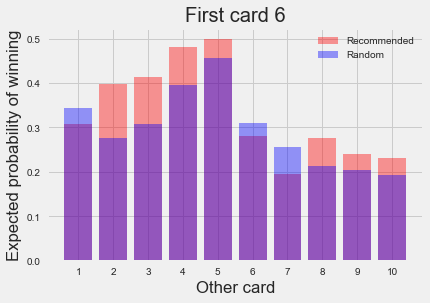

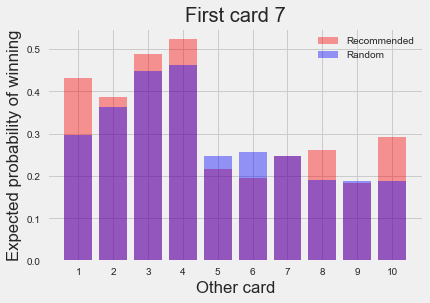

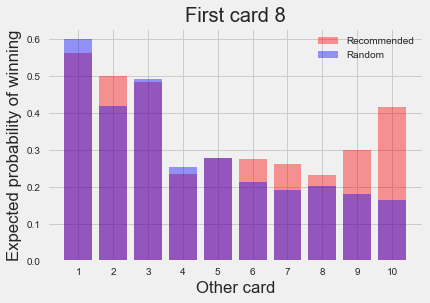

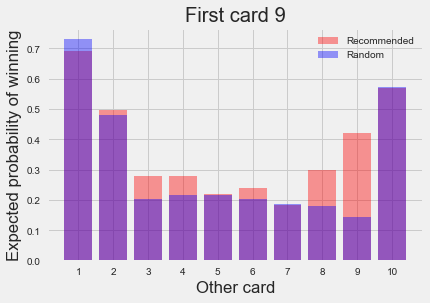

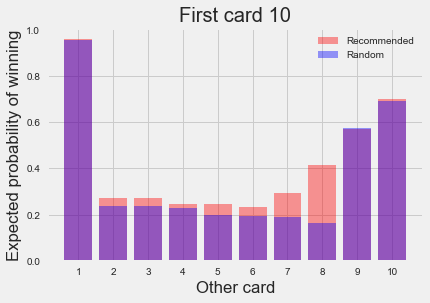

In [107]:
for i in range(1,11):
    test_doubles(i)

### Understanding the bar charts

- Each bar represents the player's '2nd' card
- The height of the bar is the expected probability that the player wins given that his 2 cards are A and B
    - i.e. If you have cards A and B, what's your chance of winning
- E.g. If you have 10 and 9, there's about a 55% chance that you will win
- This doesn't take into account what the dealer's open card it
- The higher the bar, the better the combination as compared to the other combinations in that chart

### Findings

- It's always better to split Aces
- There's a chance that splitting 2s will improve your chances of winning, but only if your next cards are 8 or 9
- Same for 3s, if your next cards are 7 or 8
- As for 4s, if your next cards are 5, 6 or 7
- Never split 5s
    - If you're holding two 5s, you have a better chance of winning than if you're holding any other combination with a 5
- If you're playing by the recommended strategy, splitting 6s will be better if your next cards are 5 or below
- As for 7s, if your next cards are 4 or below
    - If your next cards are 8 or 10, you have a slightly better chance too
- Splitting 8s always increases your chances of winning
    - But it increases much more if your next cards are 3 or below
- Splitting 9s only work if your next cards are Ace, 2 or 10
- Splitting 10s is never a good idea
    - There's a very low chance that you'll get an Ace next

## Do we always do better when hitting on 12-16's?

In [108]:
sub1216 = df.copy()

In [110]:
sub1216 = sub1216[sub1216["player_initial"] >= 12]
sub1216 = sub1216[sub1216["player_initial"] <= 16]
sub1216.reset_index(inplace=True)

In [125]:
results1216 = sub1216.groupby(["player_hit"])["player_wins"].agg([sum,len])
results1216.reset_index(inplace=True)
results1216

,player_hit,sum,len
0,0,1707,8029
1,1,4854,18499


In [126]:
results1216["win_prob"] = results1216["sum"]/results1216["len"]

In [127]:
results1216

,player_hit,sum,len,win_prob
0,0,1707,8029,0.212604
1,1,4854,18499,0.262393


In [129]:
stats.ttest_ind(sub1216["player_wins"][sub1216["player_hit"] == 0], 
                sub1216["player_wins"][sub1216["player_hit"] == 1])

Ttest_indResult(statistic=-8.6464401500979342, pvalue=5.6077515294482979e-18)

## Do we always do worse when hitting on 17's and above?

In [130]:
sub17 = df.copy()

In [131]:
sub17 = sub17[sub17["player_initial"] >= 17]
sub17.reset_index(inplace=True)

In [132]:
results17 = sub17.groupby("player_hit")["player_wins"].agg([sum, len])
results17.reset_index(inplace=True)

In [133]:
results17

,player_hit,sum,len
0,0,10567,16882
1,1,837,3959


In [134]:
results17["win_prob"] = results17["sum"]/results17["len"]

In [135]:
results17

,player_hit,sum,len,win_prob
0,0,10567,16882,0.625933
1,1,837,3959,0.211417


In [137]:
stats.ttest_ind(sub17["player_wins"][sub17["player_hit"] == 0], 
                sub17["player_wins"][sub17["player_hit"] == 1])

Ttest_indResult(statistic=49.89330452423242, pvalue=0.0)

## Chance of winning
Disregarding the recommended strategy, given the dealer's open card and your current points, what's your chance of winning?

In [220]:
sub = df[df.strategy==0].groupby(["dealer_open", "player_initial", "player_hit"])["player_wins"].agg([sum, len])
sub.reset_index(inplace=True)
sub["win_prob"] = sub["sum"]/sub["len"]
sub["p_hit"] = sub["player_hit"].apply(lambda x: "Stand" if x == 0 else "Hit")
sub.head()

,dealer_open,player_initial,player_hit,sum,len,win_prob,p_hit
0,1,4,0,0,7,0.000000,Stand
1,1,4,1,1,11,0.090909,Hit
2,1,5,0,0,5,0.000000,Stand
3,1,5,1,3,23,0.130435,Hit
4,1,6,0,0,14,0.000000,Stand


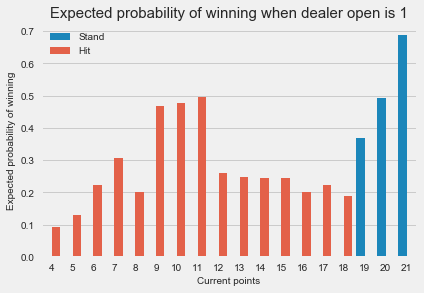

In [214]:
sns.barplot(x="player_initial", y="win_prob", hue="p_hit", data=sub[(sub["dealer_open"] == 1)]);
plt.title("Expected probability of winning when dealer open is {}".format(1), fontsize=15);
plt.ylabel("Expected probability of winning", fontsize=10);
plt.xlabel("Current points", fontsize=10);
plt.legend();

In [215]:
def open_compare(open_card):
    sns.barplot(x="player_initial", y="win_prob", hue="p_hit", data=sub[(sub["dealer_open"] == open_card)]);
    plt.title("Expected probability of winning when dealer open is {}".format(open_card), fontsize=15);
    plt.ylabel("Expected probability of winning", fontsize=10);
    plt.xlabel("Current points", fontsize=10);
    plt.legend();
    plt.show();

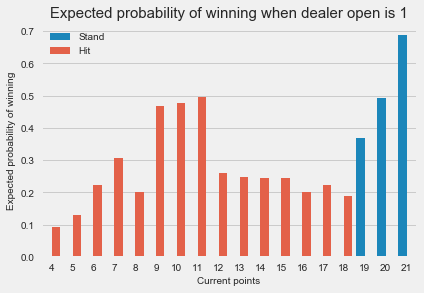

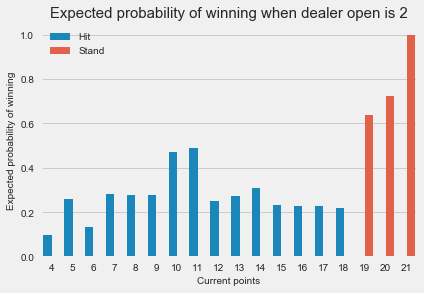

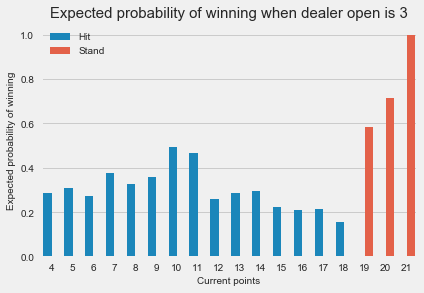

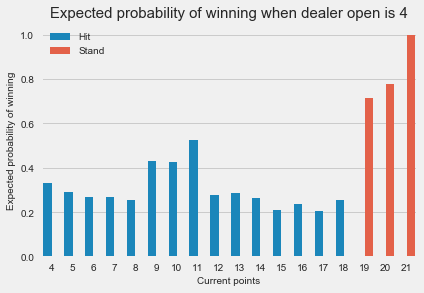

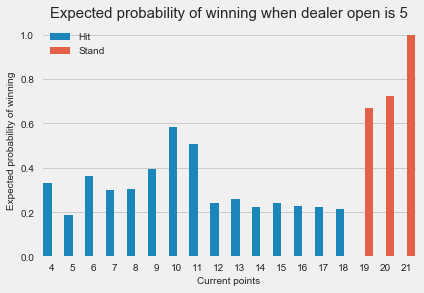

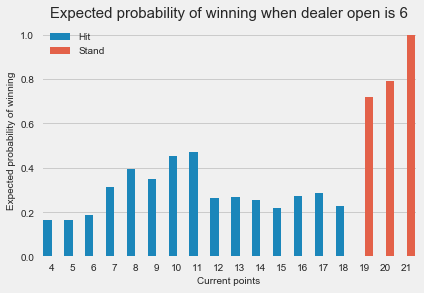

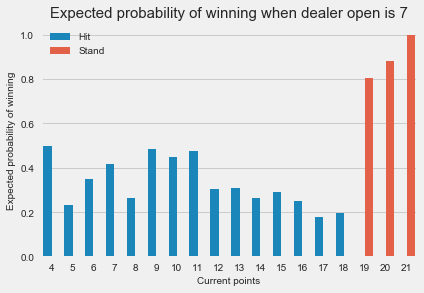

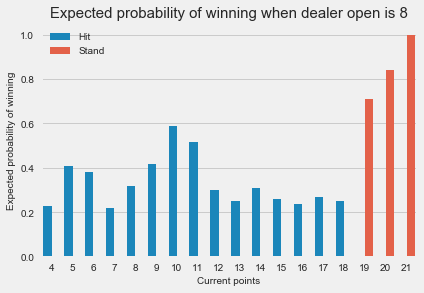

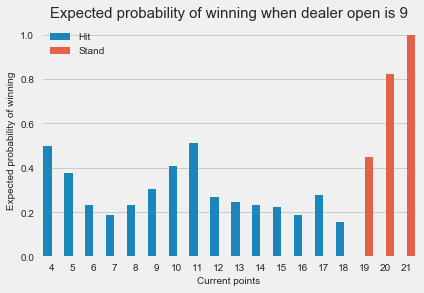

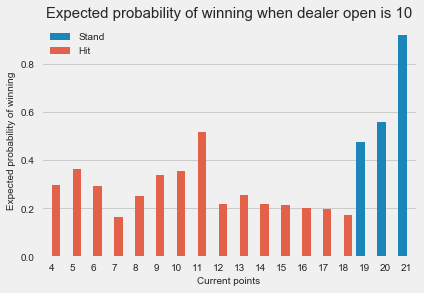

In [216]:
for i in range(1, 11):
    open_compare(i)

In [217]:
def points_compare(points):
    sns.barplot(x="dealer_open", y="win_prob", hue="p_hit", data=sub[(sub["player_initial"] == points)]);
    plt.title("Expected probability of winning when {} points".format(points), fontsize=15);
    plt.ylabel("Expected probability of winning", fontsize=10);
    plt.xlabel("Dealer open", fontsize=10);
    plt.legend();
    plt.show();

In [218]:
sub[sub.player_initial == 15]

,dealer_open,player_initial,player_hit,sum,len,win_prob,p_hit
22,1,15,0,0,58,0.000000,Stand
23,1,15,1,36,148,0.243243,Hit
44,2,15,1,47,200,0.235000,Hit
62,3,15,1,48,213,0.225352,Hit
80,4,15,1,35,165,0.212121,Hit
98,5,15,1,46,190,0.242105,Hit
116,6,15,1,38,172,0.220930,Hit
134,7,15,1,59,201,0.293532,Hit
152,8,15,1,50,191,0.261780,Hit
170,9,15,1,39,175,0.222857,Hit


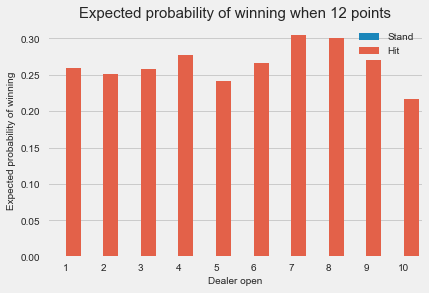

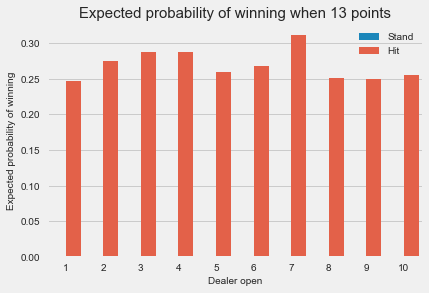

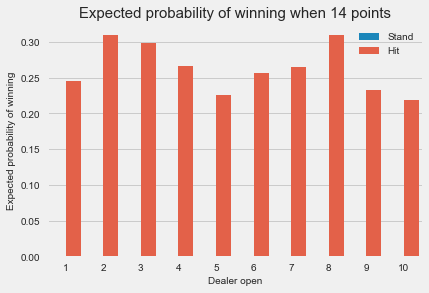

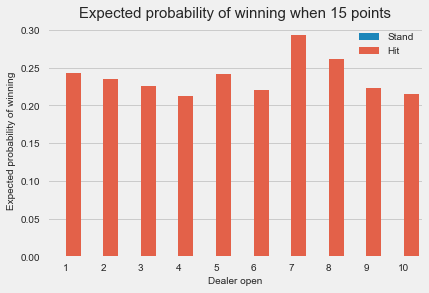

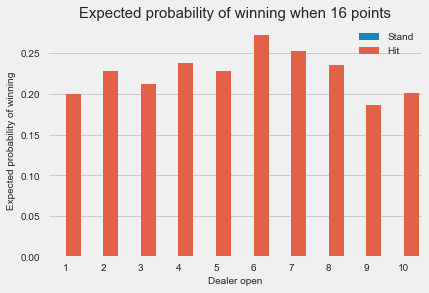

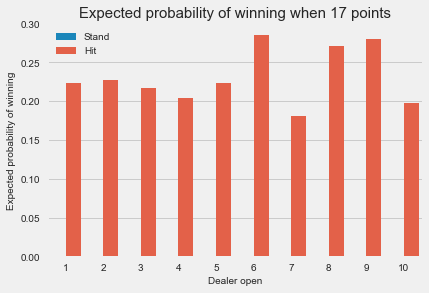

In [219]:
for i in range(12,18):
    points_compare(i)